Import modules

In [1]:
from lib.datasets import train_test_split,get_OU,rolling_window_1D
from lib.aug import apply_augmentations,parse_augmentations,sig_normal
import torch
from torch import nn
import torch.nn.functional as F
from lib.utils import set_seed
import signatory
from models.vae import VAE, VAE_train
from models.betavae import BetaVAE, BetaVAE_train
from models.infovae import InfoVAE, InfoVAE_train
from models.wae import WAE,WAE_train
from lib.metrics import mmd_loss, SignatureKernel, RBFKernel, LinearKernel
import numpy as np
import matplotlib.pyplot as plt

In [2]:
set_seed(0)

The considered truncated signature degree.

In [3]:
sig_degree = [3,4,5]

Get synthetic data.

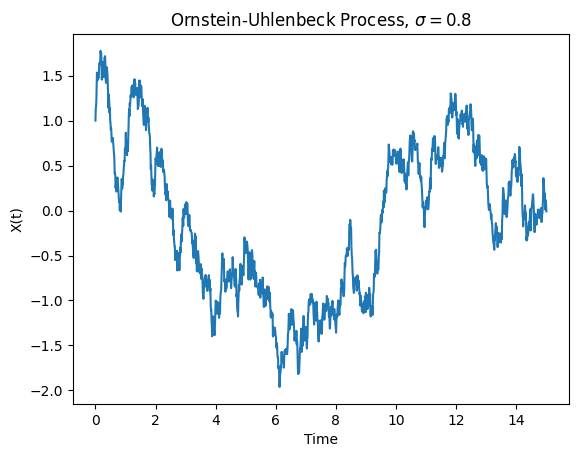

In [4]:
T = 15
dt = 0.01
N = int(T/dt)
sigma_1 = 0.8
ou_process_1 = get_OU(T=T,sigma=sigma_1).astype(np.float32)

# Plot the result
plt.plot(np.linspace(0, T, N), ou_process_1)
plt.title("Ornstein-Uhlenbeck Process, $\sigma=0.8$")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.show()


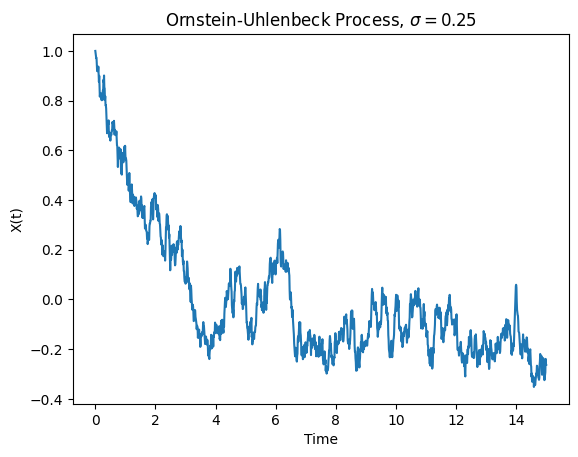

In [5]:
sigma_2 = 0.25
ou_process_2 = get_OU(T=T,sigma=sigma_2).astype(np.float32)

# Plot the result
plt.plot(np.linspace(0, T, N), ou_process_2)
plt.title("Ornstein-Uhlenbeck Process, $\sigma=0.25$")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.show()

In [6]:
sig_degree = [3,4,5]
sig_config = {
    "augmentations": [{"name": "LeadLag"}],
    "device" : "cuda",
    "depth" : sig_degree[0], # degree = 3
}

Get path augmentations.

In [7]:
if sig_config["augmentations"] is not None:
    sig_config["augmentations"] = parse_augmentations(sig_config.get('augmentations'))

Data preprocessing.
- Apply rolling window.
- Split training data and testing data.
- Apply path augmentations to original path.
- Calculate signature.
- Normalize signatures.
- Pass to CUDA.

In [8]:
tensor_data_1 = rolling_window_1D(torch.from_numpy(ou_process_1),window_size=30).view(-1,30,1)
tensor_data_2 = rolling_window_1D(torch.from_numpy(ou_process_2),window_size=30).view(-1,30,1)


x_real_train_1, x_real_test_1 = train_test_split(tensor_data_1, train_test_ratio=0.8, device=sig_config["device"])
print("x_real_train_1 shape {}, x_real_test shape {}".format(x_real_train_1.shape,x_real_test_1.shape))
x_real_train_2, x_real_test_2 = train_test_split(tensor_data_2, train_test_ratio=0.8, device=sig_config["device"])
print("x_real_train_1 shape {}, x_real_test shape {}".format(x_real_train_2.shape,x_real_test_2.shape))

if sig_config["augmentations"] is not None:
    # Print the tensor shape after each augmentation
    x_aug_train_1, x_aug_test_1 = apply_augmentations(x_real_train_1,sig_config["augmentations"]), apply_augmentations(x_real_test_1,sig_config["augmentations"])
    x_aug_train_2, x_aug_test_2 = apply_augmentations(x_real_train_2,sig_config["augmentations"]), apply_augmentations(x_real_test_2,sig_config["augmentations"])
print("After augmentation shape:",x_aug_train_1.shape)

# To signature
x_sig_train_1, x_sig_test_1 = signatory.signature(x_aug_train_1,sig_config["depth"]),signatory.signature(x_aug_test_1,sig_config["depth"])
x_sig_train_2, x_sig_test_2 = signatory.signature(x_aug_train_2,sig_config["depth"]),signatory.signature(x_aug_test_2,sig_config["depth"])
print("x_sig_train shape {}, x_sig_test shape {}".format(x_sig_train_1.shape,x_sig_test_1.shape))
input_dim = x_sig_train_1.shape[1]
print("input_dim: {}".format(input_dim))

# Normalize
x_sig_train_1, x_sig_test_1 = sig_normal(x_sig_train_1,True).to(sig_config["device"]), sig_normal(x_sig_test_1,True).to(sig_config["device"])
x_sig_train_2, x_sig_test_2 = sig_normal(x_sig_train_2,True).to(sig_config["device"]), sig_normal(x_sig_test_2,True).to(sig_config["device"])

Tensor shape before rolling: torch.Size([1500])
Tensor shape after rolling: torch.Size([1471, 30])
Tensor shape before rolling: torch.Size([1500])
Tensor shape after rolling: torch.Size([1471, 30])
x_real_train_1 shape torch.Size([1176, 30, 1]), x_real_test shape torch.Size([295, 30, 1])
x_real_train_1 shape torch.Size([1176, 30, 1]), x_real_test shape torch.Size([295, 30, 1])
torch.Size([1176, 59, 2])
torch.Size([295, 59, 2])
torch.Size([1176, 59, 2])
torch.Size([295, 59, 2])
After augmentation shape: torch.Size([1176, 59, 2])
x_sig_train shape torch.Size([1176, 14]), x_sig_test shape torch.Size([295, 14])
input_dim: 14


In [9]:
# For degree = 3
hidden_dim_degree3 = [input_dim,7,3] # input_dim = 14

# For degree = 4
hidden_dim_degree4 = [input_dim,15,7] # input_dim = 30

# For degree = 5
hidden_dim_degree5 = [input_dim,32,16] # input_dim = 62

Set degree = 3. Train models for $\sigma=0.8$

In [10]:
# VAE
model_vae = VAE(x_aug_sig=x_sig_train_1,epoch=6000,batch_size=128,device="cuda",hidden_dims=hidden_dim_degree3)
vae_optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-4)
VAE_train(model_vae,optimizer=vae_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Epoch 0 loss 1.82
Epoch 100 loss 1.92
Epoch 200 loss 1.53
Epoch 300 loss 2.76
Epoch 400 loss 1.87
min_loss: 1.41


In [11]:
# Beta-VAE
model_betavae = BetaVAE(x_sig_train_1,6000,128,beta=3.5,device='cuda',hidden_dims=hidden_dim_degree3)
beta_optimizer = torch.optim.Adam(model_betavae.parameters(), lr=1e-4)
BetaVAE_train(model=model_betavae,optimizer=beta_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Beta: 3.5
Epoch 0 loss 30.18
Epoch 100 loss 29.19
Epoch 200 loss 24.67
Epoch 300 loss 41.63
Epoch 400 loss 24.84
Epoch 500 loss 28.21
Epoch 600 loss 29.78
Epoch 700 loss 29.30
Epoch 800 loss 27.07
Epoch 900 loss 26.19
min_loss: 20.26


In [12]:
# Info-VAE
model_infovae = InfoVAE(x_aug_sig=x_sig_train_1,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
info_optimizer = torch.optim.Adam(model_infovae.parameters(), lr=1e-4) 
InfoVAE_train(model_infovae,info_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Epoch 0 loss 1.93
Epoch 100 loss 2.25
Epoch 200 loss 1.97
Epoch 300 loss 2.17
Epoch 400 loss 2.26
min_loss: 1.71


In [13]:
# WAE-MMD
model_waemmd = WAE(x_aug_sig=x_sig_train_1,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
cvae_optimizer = torch.optim.Adam(model_waemmd.parameters(), lr=1e-4) 
WAE_train(model_waemmd,cvae_optimizer)

Epoch 0 loss 1.91
Epoch 100 loss 2.14
Epoch 200 loss 2.18
Epoch 300 loss 2.11
Epoch 400 loss 2.62
Epoch 500 loss 2.02
Epoch 600 loss 2.06
Epoch 700 loss 1.99
min_loss: 1.45


Evaluate.

In [14]:
KLD = nn.KLDivLoss(reduction="batchmean")
sigkernel = SignatureKernel(static_kernel=RBFKernel(sigma=1.0))

In [15]:
models = [model_vae,model_betavae,model_infovae,model_waemmd]
ou08_vae_d3 = []
ou08_betavae_d3 = []
ou08_infovae_d3 = []
ou08_wae_d3 = []
for i in range(len(models)):
    model = models[i]
    _, _, z = model_vae.encode(x_sig_test_1)
    reconstructed_sig = model_vae.decode(z)
    reconstructed_sig = sig_normal(reconstructed_sig,True)

    # Mean of L2 norm over the batch dimension
    L2 = F.mse_loss(x_sig_test_1,reconstructed_sig)
    # Mean of JS divergence over the batch dimension
    js = (KLD(x_sig_test_1,reconstructed_sig)+KLD(reconstructed_sig,x_sig_test_1))/2
    # signature MMD
    mmd = mmd_loss(x_sig_test_1,reconstructed_sig,sigkernel)

    values = [L2.item(),js.item(),mmd.item()]

    if i==0:
        ou08_vae_d3.extend(values)
    elif i==1:
        ou08_betavae_d3.extend(values)
    elif i==2:
        ou08_infovae_d3.extend(values)
    else:
        ou08_wae_d3.extend(values)

    print("L2 ({}): {:.3f}".format(model.type,L2.item()))
    print("JS ({}): {:.3f}".format(model.type,js.item()))
    print("mmd ({}): {:.3f}".format(model.type,mmd.item()))

L2 (VAE): 1.978
JS (VAE): 1.003
mmd (VAE): 0.099
L2 (Beta-VAE): 1.912
JS (Beta-VAE): 0.726
mmd (Beta-VAE): 0.103
L2 (Info-VAE): 2.043
JS (Info-VAE): 1.516
mmd (Info-VAE): 0.104
L2 (WAE): 1.934
JS (WAE): 0.874
mmd (WAE): 0.107


Plot training loss.

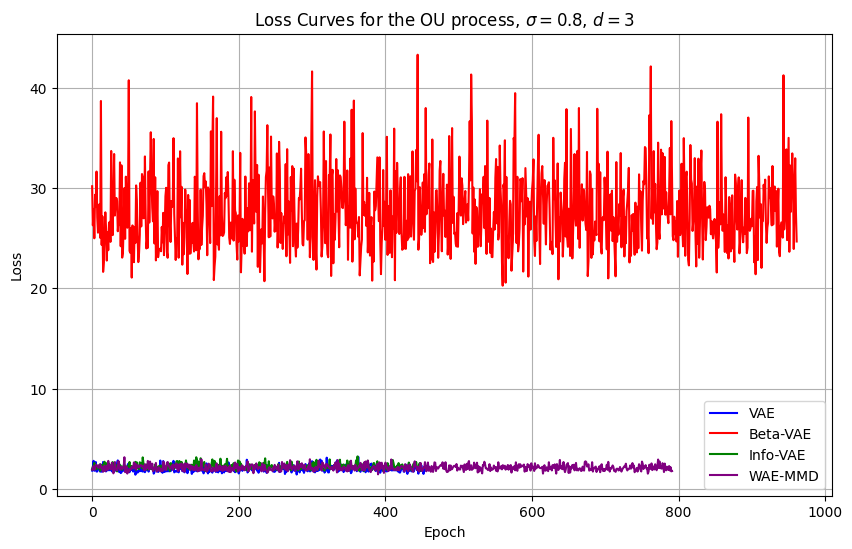

In [16]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 6))

# Plot each model's loss with a different label and color
plt.plot(range(len(model_vae.loss_record)), model_vae.loss_record, label='VAE', color='blue')
plt.plot(range(len(model_betavae.loss_record)), model_betavae.loss_record, label='Beta-VAE', color='red')
plt.plot(range(len(model_infovae.loss_record)), model_infovae.loss_record, label='Info-VAE', color='green')
plt.plot(range(len(model_waemmd.loss_record)), model_waemmd.loss_record, label='WAE-MMD', color='purple')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves for the OU process, $\sigma=0.8$, $d=3$')
plt.legend()  # Add a legend to distinguish the models
plt.grid(True)  # Optional: adds a grid for better readability
plt.savefig('assets/loss/loss_ou0.8_d3.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set degree = 3. Train models for $\sigma=0.25$

In [17]:
# VAE
model_vae = VAE(x_aug_sig=x_sig_train_2,epoch=6000,batch_size=128,device="cuda",hidden_dims=hidden_dim_degree3)
vae_optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-4)
VAE_train(model_vae,optimizer=vae_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Epoch 0 loss 2.34
Epoch 100 loss 1.61
Epoch 200 loss 1.89
Epoch 300 loss 2.48
Epoch 400 loss 1.63
min_loss: 1.44


In [18]:
# Beta-VAE
model_betavae = BetaVAE(x_sig_train_2,6000,128,beta=3.5,device='cuda',hidden_dims=hidden_dim_degree3)
beta_optimizer = torch.optim.Adam(model_betavae.parameters(), lr=1e-4)
BetaVAE_train(model=model_betavae,optimizer=beta_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Beta: 3.5
Epoch 0 loss 22.49
Epoch 100 loss 24.73
Epoch 200 loss 23.31
Epoch 300 loss 32.74
Epoch 400 loss 27.47
min_loss: 20.36


In [19]:
# Info-VAE
model_infovae = InfoVAE(x_aug_sig=x_sig_train_2,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
info_optimizer = torch.optim.Adam(model_infovae.parameters(), lr=1e-4) 
InfoVAE_train(model_infovae,info_optimizer)

Input tensor shape: torch.Size([1176, 14])
Hidden dims: [14, 7, 3]
Epoch 0 loss 2.11
Epoch 100 loss 2.56
Epoch 200 loss 2.02
Epoch 300 loss 2.32
Epoch 400 loss 2.47
min_loss: 1.79


In [20]:
# WAE-MMD
model_waemmd = WAE(x_aug_sig=x_sig_train_2,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
cvae_optimizer = torch.optim.Adam(model_waemmd.parameters(), lr=1e-4) 
WAE_train(model_waemmd,cvae_optimizer)

Epoch 0 loss 1.79
Epoch 100 loss 2.25
Epoch 200 loss 2.33
Epoch 300 loss 2.59
Epoch 400 loss 1.89
Epoch 500 loss 2.01
Epoch 600 loss 2.24
Epoch 700 loss 1.94
min_loss: 1.48


In [21]:
models = [model_vae,model_betavae,model_infovae,model_waemmd]
ou025_vae_d3 = []
ou025_betavae_d3 = []
ou025_infovae_d3 = []
ou025_wae_d3 = []
for i in range(len(models)):
    model = models[i]
    _, _, z = model_vae.encode(x_sig_test_2)
    reconstructed_sig = model_vae.decode(z)
    reconstructed_sig = sig_normal(reconstructed_sig,True)

    # Mean of L2 norm over the batch dimension
    L2 = F.mse_loss(x_sig_test_2,reconstructed_sig)
    # Mean of JS divergence over the batch dimension
    js = (KLD(x_sig_test_2,reconstructed_sig)+KLD(reconstructed_sig,x_sig_test_2))/2
    # signature MMD
    mmd = mmd_loss(x_sig_test_2,reconstructed_sig,sigkernel)

    values = [L2.item(),js.item(),mmd.item()]

    if i==0:
        ou025_vae_d3.extend(values)
    elif i==1:
        ou025_betavae_d3.extend(values)
    elif i==2:
        ou025_infovae_d3.extend(values)
    else:
        ou025_wae_d3.extend(values)

    print("L2 ({}): {:.3f}".format(model.type,L2.item()))
    print("JS ({}): {:.3f}".format(model.type,js.item()))
    print("mmd ({}): {:.3f}".format(model.type,mmd.item()))

L2 (VAE): 2.104
JS (VAE): 1.000
mmd (VAE): 0.080
L2 (Beta-VAE): 2.109
JS (Beta-VAE): 1.025
mmd (Beta-VAE): 0.082
L2 (Info-VAE): 2.000
JS (Info-VAE): 0.582
mmd (Info-VAE): 0.077
L2 (WAE): 2.007
JS (WAE): 0.686
mmd (WAE): 0.080


Plot training loss.

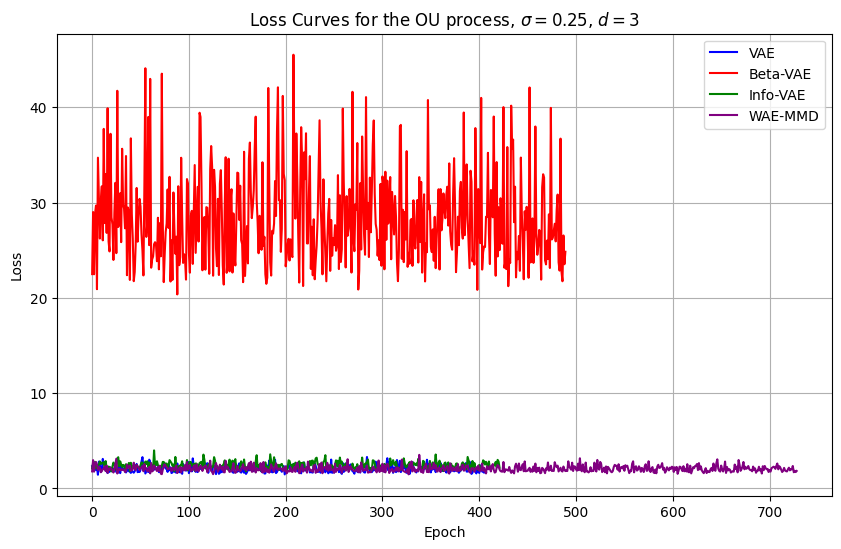

In [22]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 6))

# Plot each model's loss with a different label and color
plt.plot(range(len(model_vae.loss_record)), model_vae.loss_record, label='VAE', color='blue')
plt.plot(range(len(model_betavae.loss_record)), model_betavae.loss_record, label='Beta-VAE', color='red')
plt.plot(range(len(model_infovae.loss_record)), model_infovae.loss_record, label='Info-VAE', color='green')
plt.plot(range(len(model_waemmd.loss_record)), model_waemmd.loss_record, label='WAE-MMD', color='purple')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves for the OU process, $\sigma=0.25$, $d=3$')
plt.legend()  # Add a legend to distinguish the models
plt.grid(True)  # Optional: adds a grid for better readability
plt.savefig('assets/loss/loss_ou0.25_d3.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [23]:
print(ou08_vae_d3)
print(ou08_betavae_d3)
print(ou08_infovae_d3)
print(ou08_wae_d3)

[1.978076696395874, 1.0032161474227905, 0.09922869503498077]
[1.9119750261306763, 0.7263525724411011, 0.10340289771556854]
[2.0434346199035645, 1.5158891677856445, 0.10406477749347687]
[1.9342496395111084, 0.8744571208953857, 0.106557697057724]


In [24]:
print(ou025_vae_d3)
print(ou025_betavae_d3)
print(ou025_infovae_d3)
print(ou025_wae_d3)

[2.1039533615112305, 0.9998356103897095, 0.07957736402750015]
[2.1094212532043457, 1.0253692865371704, 0.08160118013620377]
[1.9997841119766235, 0.5820349454879761, 0.07723899185657501]
[2.0071322917938232, 0.685705840587616, 0.07983032613992691]
